# Tarea 1: Multi-armed bandits
## IELE 4922: Reinforcement Learning
## Wilmar Calderón
## 201630701


### 0. Inicialización de librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Inicializaicón de los parámetros de los modelos
    #Número de los bandits (Acciones)
n_bandits=10
    #Media de las acciones q*
mean_q=0
    #Varianza de las acciones q*
variance_q=1
    #Varianza de cada acción (recompensa)
action_var=1
    #Número de pasos: horizonte
steps=1000
    #número de iteraciones (repeticiones del experimento)
iter=100

### 1. Acerca de los multi-armed bandits

In [3]:
# Función para generar una visualización de q*(a_k)
#num_actions por definición será igual al número de bandits (entrada por parámetro para permitir la escalabilidad de la función)

def generate_q(mean, variance, num_actions, steps,step_variance):
    q_ast=np.zeros((steps,num_actions))
    q_ini=np.random.normal(mean, np.sqrt(variance), num_actions)
    for i,mean_q in enumerate(q_ini):
        q_ast[:,i]=np.random.normal(mean_q, np.sqrt(step_variance), steps)
    return q_ast

q_val=generate_q(mean_q,variance_q,n_bandits,steps,action_var)

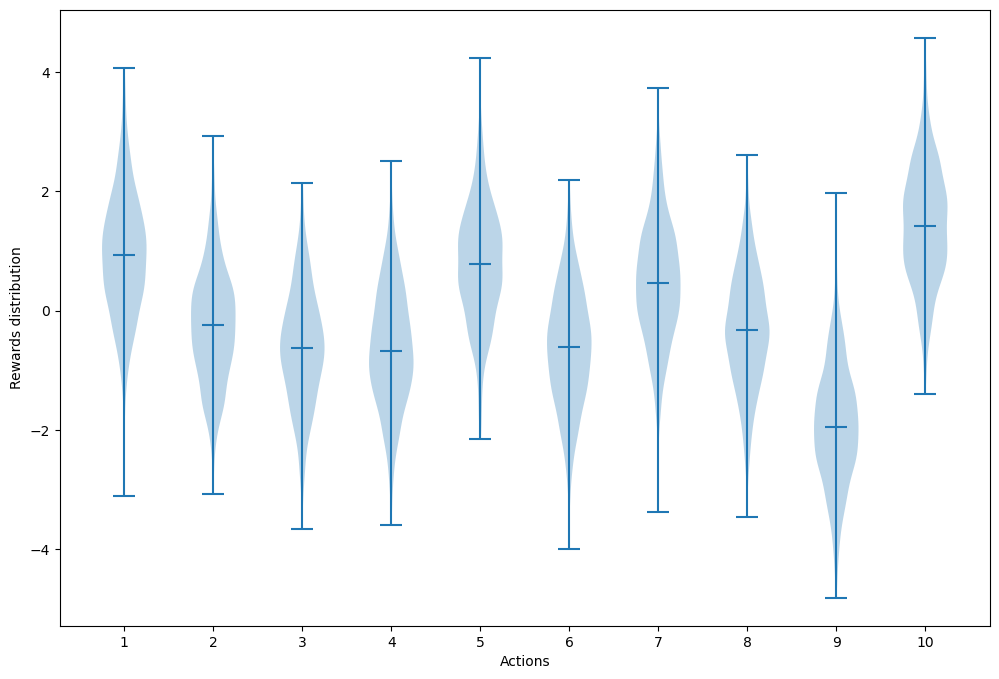

In [4]:
plt.figure(figsize=(12,8))
plt.ylabel('Rewards distribution')
plt.xlabel('Actions')
plt.xticks(range(1,n_bandits+1))

plt.violinplot(q_val, positions=range(1,n_bandits+1), showmedians=True)
plt.show()

### 1.A $\varepsilon$-greedy

In [5]:
# Función que obtiene el índice del máximo valor dentro de un arreglo (útil para calcular ese bandit que maximiza la recompensa)
# input: valores de las recompensas (arreglo)
# output: índice de la posición que corresponde al valor máximo dentro del arreglo
def arg_max(q_ast):
    arg_max_i=np.argmax(q_ast)
    if isinstance(arg_max_i, list):
        return arg_max_i[0]
    else:
        return arg_max_i

# Función para obtener las recompensas de las acciones a tomar. Considera un número aleatorio que sigue una distribución normal centrada en q* y con varianza definida (parámetro)
# input: un arreglo con las estimaciones iniciales de las recompensas
# output: un arreglo con valores de una distribución normal centrada en en q_ast (parámetro) y var_action (parámetro)
def f_rewards(q_ast,var_action):
    return np.random.normal(q_ast,np.sqrt(var_action))




Para el caso de la implementación del algoritmo $\varepsilon$ -_greedy_ se seguirá el pseudocódigo planteado por (Sutton & Barto, 2018) en el capítulo 2:

In [6]:
# Definición de función para entrenar a los bandits de acuerdo con la política epsilon-greedy
# input: epsilon (float), num_bandits (int), steps -u horizonte-(int), iter (int)
# output: Recompensa promedio obtenida de cada paso en las diferentes iteraciones, así como el porcentaje de iteraciones en que se selecciona la acción óptima
def epsilon_greedy (epsilon,num_bandits,steps,iter):
        #arreglo para almacenar las recompensas promedio en todo el horizonte
    avg_reward=np.zeros(steps)
        #arreglo para almacenar el conteo de iteraciones en las que se selecciona la acción óptima
    optimal_count=np.zeros(steps)

        #ciclo a través de las iteraciones evalaudas
    for i in range(iter):
            #arreglo para almacenar los valores de la recompensa esperada de cada acción tomada
        q_a=np.zeros(n_bandits)
            #arreglo que contabiliza el número de iteraciones evalaudas hasta el momento de evaluación
        n=np.zeros(n_bandits)
            #arreglo que almacena la recompensa total por número de episodios evaluados
        rewards=np.zeros(steps)
            #arreglo que almacena si se encuentra un óptimo (útil para encontrar el porcentaje de encontrar óptimo)
        optimal_found=np.zeros(steps)

            #inicialización de valores q* para la iteración de evaluación        
        q_ini= np.random.normal(mean_q,np.sqrt(variance_q),n_bandits)
            #inicialziación del valor teórico máximo
        max_ini=arg_max(q_ini)

            #ciclo dentro de todos los periodos desde 0 hasta el horizonte
        for s in range(steps):

            act=0 #representa el bandit que se activa en la acción
            if np.random.rand()<epsilon:
                act=int(np.random.randint(num_bandits))
            else:
                act=int(arg_max(q_a))

                #cálculo de la recompensa dado un bandit seleccionado y una varianza definida
            reward_i=f_rewards(q_ini[act],action_var)
            
                #actualiza el n+umero de evaluación de la iteración
            n[act]+=1
                #implementación incremental: permite el aprendizaje 
            q_a[act]+=(reward_i-q_a[act])/n[act]

                #alamcenamiento de la información de la recompensa y el número de iteraciones requeridas para el óptimo
            rewards[s]=reward_i
            if (act==max_ini):
                optimal_found[s]=1
            #cálculo de las métricas establecidas (recompensa y porcentaje de iteraciones en encontrar el óptimo) para todas las iteraciones
        avg_reward +=rewards
        optimal_count +=optimal_found

        #retorna las métricas ponderadas dentro de las _iter_ veces que se evaluó el código    
    out_1=avg_reward/iter
    out_2=optimal_count/iter
    return out_1,out_2



In [7]:
#definición de la lista de epsilon que se quiere evaluar
epsilons=[0.0]

#Función para evaluar múltiples valores para epsilon en la uimplementación de epsilon-greedy
def eval_eps(epsilons):
        #arreglos vaciós en dónde se almacenará la información de las diferentes corridas
    avg_r=np.zeros((steps,len(epsilons)))
    optimal_res=np.zeros((steps,len(epsilons)))
        #evalaución de las combinacioens de número de iteraciones y valor de epsilon para la evaluación
    for e in range(len(epsilons)):
        rewards,percent=epsilon_greedy(epsilons[e],n_bandits,steps,iter)
        avg_r[:,e]=rewards
        optimal_res[:,e]=percent   
    return avg_r,optimal_res


steps_arr=np.arange(0,steps,dtype=int)
avg_r,optimal_r=eval_eps(epsilons)

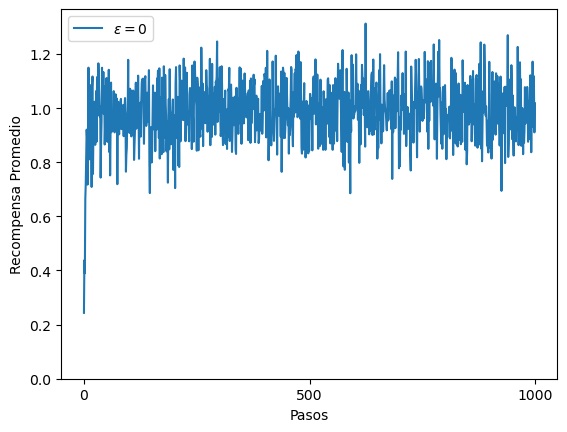

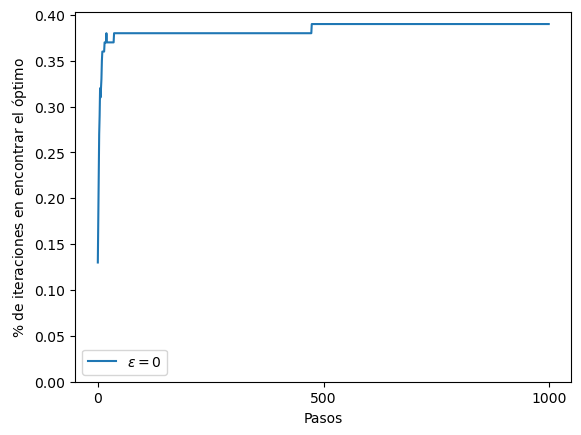

In [8]:
#gráfica para la recompensa
plt.figure()
plt.plot(avg_r[:,0],label=f"$\epsilon=0$")
# plt.plot(avg_r[:,1],c="r",label=f"$\epsilon=0.01$")
# plt.plot(avg_r[:,2],c="g",label=f"$\epsilon=0.1$")
plt.xticks(range(0,steps+1,500))
plt.xlabel("Pasos")
plt.ylabel("Recompensa Promedio")
plt.ylim(0)
plt.legend()
plt.show()

#Gráfica para el % de iteraciones al óptimo
plt.figure()
plt.plot(optimal_r[:,0],label=f"$\epsilon=0$")
# plt.plot(optimal_r[:,1],c="r",label=f"$\epsilon=0.01$")
# plt.plot(optimal_r[:,2],c="g",label=f"$\epsilon=0.1$")
plt.xticks(range(0,steps+1,500))
plt.xlabel("Pasos")
plt.ylabel("$\%$ de iteraciones en encontrar el óptimo")
plt.ylim(0)
plt.legend()
plt.show()


### 1.B Gradient Bandit

In [9]:
# Función para entrenar a los bandits de acuerdo con la política gradient bandit
# input: alpha (float), num_bandits (int), steps -u horizonte-(int), iter (int)
# output: Recompensa promedio obtenida de cada paso en las diferentes iteraciones, así como el porcentaje de iteraciones en que se selecciona la acción óptima de acuerdo con
# la metodología de gradient bandit.

def gradient_bandit (alpha,num_bandits,steps,iter):
        #arreglo para almacenar las recompensas promedio en todo el horizonte
    avg_reward=np.zeros(steps)
        #arreglo para almacenar el conteo de iteraciones en las que se selecciona la acción óptima
    optimal_count=np.zeros(steps)

        #ciclo a través de las iteraciones evalaudas
    for i in range(iter):
        
            #(Sutton & Barto): Initially all action preferences are the same (e.g., H1(a) = 0, for all a) so that all actions have an equal probability of being selected.
        preferences = np.zeros(n_bandits)
        pi_a= np.ones(n_bandits)/n_bandits

            #arreglo que almacena la recompensa total por número de episodios evaluados
        rewards=np.zeros(steps)
            #arreglo que almacena si se encuentra un óptimo (útil para encontrar el porcentaje de encontrar óptimo)
        optimal_found=np.zeros(steps)

            #inicialización de valores q* para la iteración de evaluación        
        q_ini= np.random.normal(mean_q,np.sqrt(variance_q),n_bandits)
            #inicialziación del valor teórico máximo
        max_ini=arg_max(q_ini)

            #ciclo dentro de todos los periodos desde 0 hasta el horizonte
        for s in range(steps):
                #selección de una acción del bandit: selección con una probabilidad guiada por las \pi (tiende a seleccionar aquel con mayor probabilida de preferencia)
            act=np.random.choice(np.arange(n_bandits),p=pi_a)
                #cálculo de la recompensa dado un bandit seleccionado y una varianza definida
            reward_i=f_rewards(q_ini[act],action_var)
            
                #(Sutton & Barto) and ¯Rt 2 R is the average of all the rewards up through and including time t, which can be computed incrementally
            baseline=rewards[:s].mean() if s>0 else 0

                #Cálculo de las preferencias de cada una de las acciones
            for k in range(n_bandits):
                if k == act:
                    preferences[k]+=alpha*(reward_i-baseline)*(1-pi_a[k])
                else:
                    preferences[k]-=alpha*(reward_i-baseline)*pi_a[k]
            
            e_x=np.exp(preferences-np.max(preferences))
            pi_a=e_x/e_x.sum()

                #alamcenamiento de la información de la recompensa y el número de iteraciones requeridas para el óptimo
            rewards[s]=reward_i

            if (act==max_ini):
                optimal_found[s]=1
            #cálculo de las métricas establecidas (recompensa y porcentaje de iteraciones en encontrar el óptimo) para todas las iteraciones
        avg_reward +=rewards
        optimal_count +=optimal_found

        #retorna las métricas ponderadas dentro de las _iter_ veces que se evaluó el código    
    out_1=avg_reward/iter
    out_2=optimal_count/iter
    return out_1,out_2

In [10]:


#definición de la lista de epsilon que se quiere evaluar
alphas=[0.1,0.4]

#Función para evaluar múltiples valores para alpha en la uimplementación de epsilon-greedy
def eval_alp(alphas):
        #arreglos vaciós en dónde se almacenará la información de las diferentes corridas
    avg_r=np.zeros((steps,len(alphas)))
    optimal_res=np.zeros((steps,len(alphas)))
        #evalaución de las combinacioens de número de iteraciones y valor de alpha para la evaluación
    for a in range(len(alphas)):
        rewards,percent=gradient_bandit(alphas[a],n_bandits,steps,iter)
        avg_r[:,a]=rewards
        optimal_res[:,a]=percent   
    return avg_r,optimal_res


steps_arr=np.arange(0,steps,dtype=int)
avg_r,optimal_r=eval_alp(alphas)

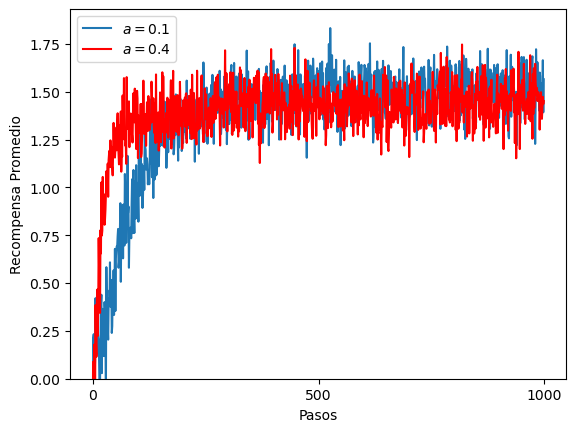

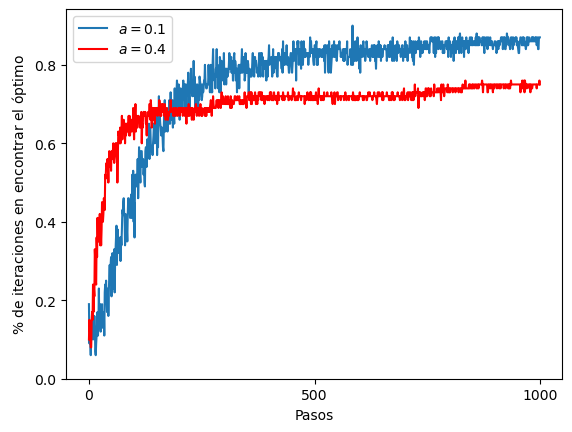

In [11]:
#gráfica para la recompensa
plt.figure()
plt.plot(avg_r[:,0],label=f"$a=0.1$")
plt.plot(avg_r[:,1],c="r",label=f"$a=0.4$")

plt.xticks(range(0,steps+1,500))
plt.xlabel("Pasos")
plt.ylabel("Recompensa Promedio")
plt.ylim(0)
plt.legend()
plt.show()

#Gráfica para el % de iteraciones al óptimo
plt.figure()
plt.plot(optimal_r[:,0],label=f"$a=0.1$")
plt.plot(optimal_r[:,1],c="r",label=f"$a=0.4$")

plt.xticks(range(0,steps+1,500))
plt.xlabel("Pasos")
plt.ylabel("$\%$ de iteraciones en encontrar el óptimo")
plt.ylim(0)
plt.legend()
plt.show()

### 2. Modificación de la varianza en la acción

### 3. No-estacionario

In [12]:
# Definición de función para entrenar a los bandits de acuerdo con la política epsilon-greedy no estacionaria
# input: epsilon (float), alpha -tamaño del paso (float) num_bandits (int), steps -u horizonte-(int), iter (int), T (int) -periodos en los que se reinicia el agente-
# output: Recompensa promedio obtenida de cada paso en las diferentes iteraciones, así como el porcentaje de iteraciones en que se selecciona la acción óptima
def epsilon_greedy_mod (epsilon,alpha,num_bandits,steps,iter,T):
        #arreglo para almacenar las recompensas promedio en todo el horizonte
    avg_reward=np.zeros(steps)
        #arreglo para almacenar el conteo de iteraciones en las que se selecciona la acción óptima
    optimal_count=np.zeros(steps)

        #ciclo a través de las iteraciones evalaudas
    for i in range(iter):
            #arreglo para almacenar los valores de la recompensa esperada de cada acción tomada
        q_a=np.zeros(n_bandits)

            #arreglo que almacena la recompensa total por número de episodios evaluados
        rewards=np.zeros(steps)
            #arreglo que almacena si se encuentra un óptimo (útil para encontrar el porcentaje de encontrar óptimo)
        optimal_found=np.zeros(steps)



            #ciclo dentro de todos los periodos desde 0 hasta el horizonte
        for s in range(steps):
            if(s % T ==0):
                    #inicialización de valores q* para la iteración de evaluación        
                q_ini= np.random.normal(mean_q,np.sqrt(variance_q),n_bandits)
                    #inicialziación del valor teórico máximo
                max_ini=arg_max(q_ini)

            act=0 #representa el bandit que se activa en la acción
            if np.random.rand()<epsilon:
                act=int(np.random.randint(num_bandits))
            else:
                act=int(arg_max(q_a))

                #cálculo de la recompensa dado un bandit seleccionado y una varianza definida
            reward_i=f_rewards(q_ini[act],action_var)
            
                #implementación incremental: permite el aprendizaje 
            q_a[act]+=(reward_i-q_a[act])*alpha

                #alamcenamiento de la información de la recompensa y el número de iteraciones requeridas para el óptimo
            rewards[s]=reward_i
            if (act==max_ini):
                optimal_found[s]=1
            #cálculo de las métricas establecidas (recompensa y porcentaje de iteraciones en encontrar el óptimo) para todas las iteraciones
        avg_reward +=rewards
        optimal_count +=optimal_found

        #retorna las métricas ponderadas dentro de las _iter_ veces que se evaluó el código    
    out_1=avg_reward/iter
    out_2=optimal_count/iter
    return out_1,out_2

In [13]:
# Inicializaicón de los parámetros de los modelos
#     Número de los bandits (Acciones)
# n_bandits=10
#     #Media de las acciones q*
# mean_q=4
#     #Varianza de las acciones q*
# variance_q=1
#     #Varianza de cada acción (recompensa)
# action_var=1
#     #Número de pasos: horizonte
# steps=1000
#     #número de iteraciones (repeticiones del experimento)
# iter=100

#definición de la lista de epsilon que se quiere evaluar
epsilons=[0.0,0.1]
alpha=[0.1,0.4]
t=[500]
#Función para evaluar múltiples valores para epsilon en la uimplementación de epsilon-greedy
def eval_eps_mod(epsilons,alpha, T):
        #arreglos vaciós en dónde se almacenará la información de las diferentes corridas
    avg_r={}
    optimal_res={}
        #evalaución de las combinacioens de número de iteraciones y valor de epsilon para la evaluación
    for e in range(len(epsilons)):
        for a in range(len(alpha)):
            for i in range(len(T)):
                rewards,percent=epsilon_greedy_mod(epsilons[e],alpha[a],n_bandits,steps,iter,T[i])
                name="eps_"+str(epsilons[e])+"_alpha_"+str(alpha[a])+"_T_"+str(T[i])
                avg_r[name]=rewards
                optimal_res[name]=percent
    return avg_r,optimal_res


steps_arr=np.arange(0,steps,dtype=int)
avg_r,optimal_r=eval_eps_mod(epsilons,alpha,t)

['eps_0.0_alpha_0.1_T_500', 'eps_0.0_alpha_0.4_T_500', 'eps_0.1_alpha_0.1_T_500', 'eps_0.1_alpha_0.4_T_500']
eps_0.0_alpha_0.1_T_500
True


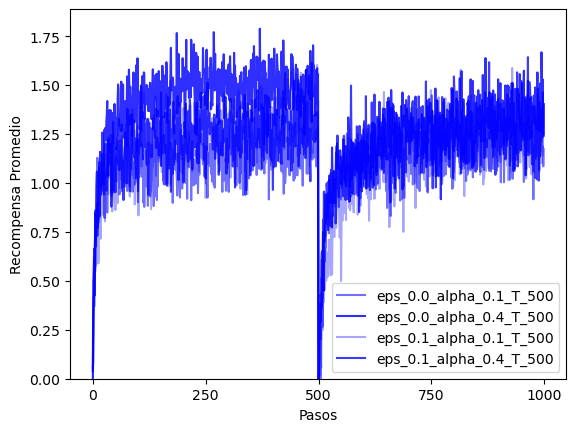

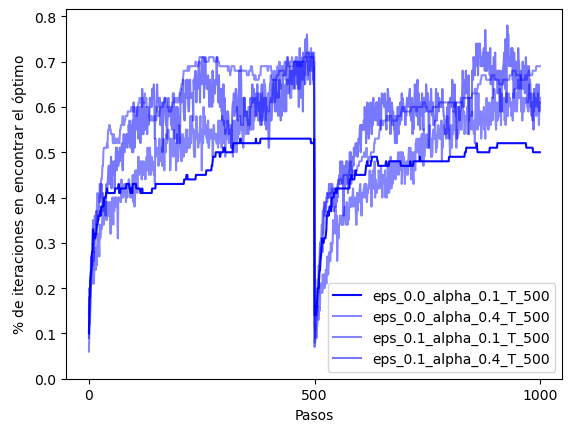

In [24]:
names=list(avg_r.keys())
colors=["blue","red","green","orange","gray","black"]
print(names)
print(names[0])
print("T_500" in names[0])
plt.figure()
for i in range(len(names)):
    #gráfica para la recompensa
    if("T_500" in names[0]):
        plt.plot(avg_r[names[i]],label=names[i],color="blue", alpha=np.random.randint(10,99)/100)
plt.xticks(range(0,steps+1,250))
plt.xlabel("Pasos")
plt.ylabel("Recompensa Promedio")
plt.ylim(0)
plt.legend()
plt.show()

#Gráfica para el % de iteraciones al óptimo
plt.figure()
for i in range(len(names)):
    #gráfica para la recompensa
    if("T_500" in names[0]):
        plt.plot(optimal_r[names[i]],label=names[i],color="blue", alpha=np.random.randint(10,99)/100)
plt.xticks(range(0,steps+1,250))
# plt.plot(optimal_r[:,1],c="r",label=f"$\epsilon=0.01$")
# plt.plot(optimal_r[:,2],c="g",label=f"$\epsilon=0.1$")
plt.xticks(range(0,steps+1,500))
plt.xlabel("Pasos")
plt.ylabel("$\%$ de iteraciones en encontrar el óptimo")
plt.ylim(0)
plt.legend()
plt.show()